In [0]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [0]:
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

from svhn_dataset import SVHN

In [5]:
dataset = SVHN().train.map(SVHN.parse)
for sample in dataset.take(10):
    pass
print(sample['image'].shape)
print(sample.keys())
sizes = np.array([x['image'].shape[0] for x in dataset.as_numpy_iterator()])
print(f'training samples: {len(sizes)}')
print(f'max size: {np.max(sizes)}')
print(f'min size: {np.min(sizes)}')
print(f'mean size: {np.mean(sizes)}')
print(f'number of samples bigger then 128: {np.sum(sizes > 128)}')
print(f'number of samples bigger then 256: {np.sum(sizes > 256)}')

(40, 40, 3)
dict_keys(['bboxes', 'classes', 'image'])
training samples: 10000
max size: 293
min size: 18
mean size: 76.3944
number of samples bigger then 128: 1011
number of samples bigger then 256: 15


size: (18, 18, 3)


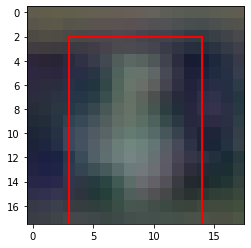

In [6]:
input_size = 128


for sample in dataset.take(6406):
    pass

@tf.function
def scale(x):
    return dict(image = x['image'],
                classes = x['classes'],
                bboxes = x['bboxes'])



def draw_image_and_bb(image, bbs):
    print(f'size: {image.shape}')
    plt.imshow(image)
    ax = plt.gca()
    for bb in bbs:
        ymin, xmin, ymax, xmax = bb.numpy()
        y, x = (ymin + ymax) / 2, (xmin + xmax) / 2
        h, w = (ymax - ymin), (xmax - xmin)
        rect = patches.Rectangle((xmin, ymin),w,h,linewidth=2,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    plt.show()
    

#print(f'max size: {max_size}')
draw_image_and_bb(sample['image'].numpy(), sample['bboxes'])

# Dataset properties
max size: 293
mean size: 76.4
number of images bigger than 128: 1011
train size: 10000

In [0]:
def generate_anchors(pyramid_levels, image_size, first_feature_scale=4, anchor_scale=4.0, aspect_ratios = [(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)], num_scales=3): 
    boxes_all = []
    for s in range(pyramid_levels):
        boxes_level = []
        for octave in range(num_scales):
            for aspect_h, aspect_w in aspect_ratios:
                scale = 2 ** (octave / num_scales)
                stride = first_feature_scale * 2 ** s
                base_anchor_size = anchor_scale * stride * scale
                anchor_size_x = base_anchor_size * aspect_w / 2.0
                anchor_size_y = base_anchor_size * aspect_h / 2.0

                x = np.arange(stride / 2, image_size, stride)
                y = np.arange(stride / 2, image_size, stride)
                xv, yv = np.meshgrid(x, y)
                xv = xv.reshape(-1)
                yv = yv.reshape(-1)

                boxes = np.vstack((yv - anchor_size_y, xv - anchor_size_x,
                    yv + anchor_size_y, xv + anchor_size_x))
                boxes = np.swapaxes(boxes, 0, 1)
                boxes_level.append(np.expand_dims(boxes, axis=1))
        boxes_level = np.concatenate(boxes_level, axis=1)
        boxes_all.append(boxes_level.reshape(-1, 4))
    return np.vstack(boxes_all) 

anchors = generate_anchors(4, 128, anchor_scale=3.0, first_feature_scale =4)

In [8]:
from importlib import reload
import efficientdet
reload(efficientdet)
net = efficientdet.EfficientDet(5, 9, input_size= 128)

In [9]:
input_tensor = tf.random.uniform((2, 128, 128, 3), dtype=tf.float32)
output = net(input_tensor)
print(output[0].shape)
print(output[1].shape)

(2, 12240, 5)
(2, 12240, 4)


In [0]:
import train
from importlib import reload
import utils
import efficientdet
import data
reload(data)
reload(train)
from data import create_data, SVHN
args, argstr = train.parse_args(['--name', 'test_test'])
args.num_scales = 1
args.aspect_ratios = [(1.4, 0.7)]

num_classes = SVHN.LABELS
pyramid_levels = args.pyramid_levels
smallest_stride = 2**(6 - pyramid_levels)
anchors = utils.generate_anchors(pyramid_levels, args.image_size, 
    first_feature_scale=smallest_stride, anchor_scale=float(smallest_stride),
    num_scales=args.num_scales, aspect_ratios=args.aspect_ratios)

train_dataset, dev_dataset, test_dataset = create_data(args.batch_size, 
            anchors, image_size = args.image_size,
            test=args.test, augmentation = args.augmentation)

# Prepare network and trainer
anchors_per_level = args.num_scales * len(args.aspect_ratios)
network = efficientdet.EfficientDet(num_classes, anchors_per_level,
            input_size = args.image_size, pyramid_levels = pyramid_levels) 
model = train.RetinaTrainer(network, anchors, train_dataset, dev_dataset, args)
model.model.load_weights('model.h5')

# Start training
# print(f'running command: {argstr}') 
# model.fit()

# Save model
# model.save()
# print('model saved')


In [50]:
print(model.evaluate())
val_predictions = model.predict(model.val_dataset, 0.9)
print(model.evaluate(model.dataset))
train_predictions = model.predict(model.dataset, 0.9)

{'loss': 8.739076, 'regression_loss': 0.06881422, 'class_loss': 8.670262}
{'loss': 0.09072387, 'regression_loss': 0.039751347, 'class_loss': 0.05097255}


size: (128, 128, 3)


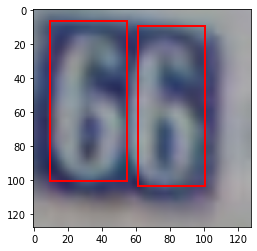

In [51]:
eval_dataset = model.val_dataset
eval_predictions = val_predictions

import numpy as np
id_pred=10
for sample in eval_dataset.batch(1).take(id_pred):
    pass

num_gt = sample['gt-length'].numpy()[0]
draw_image_and_bb(sample['image'][0,...].numpy(), sample['gt-bbox'][0,...][:num_gt])

GT data
size: (128, 128, 3)


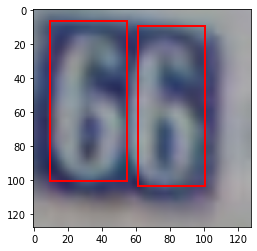

GT matched anchors
size: (128, 128, 3)


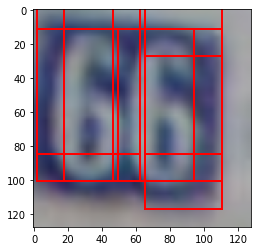

In [52]:
print('GT data')
valid_data = sample['class'][0].numpy().max(-1).astype(np.bool)
matched_anchors = utils.bbox_from_fast_rcnn(model.anchors, sample['bbox'])
anchor_data = matched_anchors.numpy()[0, valid_data,:]
draw_image_and_bb(sample['image'][0,...].numpy(), tf.convert_to_tensor(anchor_data))

print('GT matched anchors')
valid_data = sample['class'][0].numpy().max(-1).astype(np.bool)
matched_anchors = utils.bbox_from_fast_rcnn(model.anchors, sample['bbox'])
anchor_data = model.anchors[valid_data,:]
draw_image_and_bb(sample['image'][0,...].numpy(), tf.convert_to_tensor(anchor_data))

size: (128, 128, 3)


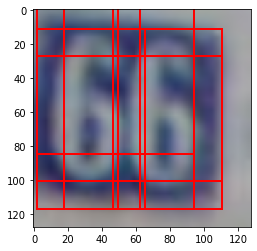

size: (128, 128, 3)


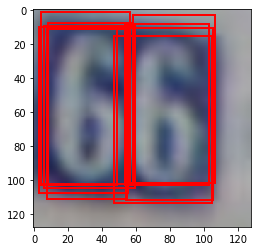

In [53]:
score_threshold = 0.5
# predicted anchors
class_pred, bbox_pred = model.model(sample['image'], training=False)
max_class = tf.nn.sigmoid(class_pred)[0].numpy().max(-1)
matched_anchors = model.anchors[max_class > score_threshold]
draw_image_and_bb(sample['image'][0,...].numpy(), tf.convert_to_tensor(matched_anchors))

# results before nonmax suppression
transformed_predictions = utils.bbox_from_fast_rcnn(model.anchors, bbox_pred)[0]
matched_results = transformed_predictions.numpy()[max_class > score_threshold]
draw_image_and_bb(sample['image'][0,...].numpy(), tf.convert_to_tensor(matched_results))

size: (128, 128, 3)


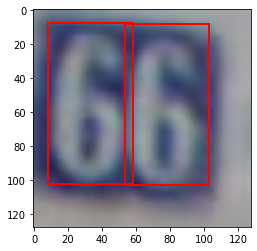

[1.]
tf.Tensor([[6. 6. 0. 0. 0.]], shape=(1, 5), dtype=float32)
size: (128, 128, 3)


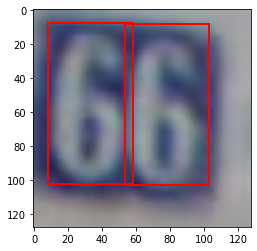

In [54]:
# Non maximum suppression
regression_pred = utils.bbox_from_fast_rcnn(model.anchors, bbox_pred) 
regression_pred = tf.expand_dims(regression_pred, 2)
class_probs = tf.nn.sigmoid(class_pred)
boxes, scores, classes, valid = tf.image.combined_non_max_suppression(
    regression_pred, class_probs, 4, 5, score_threshold=0.9,
    iou_threshold=0.2, clip_boxes=False)

boxes = tf.clip_by_value(boxes, 0, 128)
npred = valid.numpy()[0]
boxes = boxes.numpy()[0,:npred,...]
draw_image_and_bb(sample['image'][0,...].numpy(), tf.convert_to_tensor(boxes))


# Verify predictions
print(eval_predictions[id_pred][2])
pboxes, _, pclasses, valid = model.predict_on_batch(sample, 0.9)
print(pclasses)
draw_image_and_bb(sample['image'][0,...].numpy(), pboxes[0])

In [0]:
with open("svhn_classification.txt", "w", encoding="utf-8") as out_file:
    # TODO: Predict the digits and their bounding boxes on the test set.
    for x, xorig in zip(test_dataset.batch(1), SVHN().test.map(SVHN.parse)):
        predicted_bboxes, _, predicted_classes, valid = model.predict_on_batch(x, 0.5)
        # Assume that for the given prediction we get its
        # - `predicted_classes`: a 1D array with the predicted digits,
        # - `predicted_bboxes`: a [len(predicted_classes), 4] array with bboxes;
        # We can then generate the required output by
        output = []
        for _, label, bbox in zip(range(valid[0].numpy()), predicted_classes.numpy()[0], predicted_bboxes[0]):
            output.append(label.astype(np.int32))
            bbox_transformed = tf.cast(tf.shape(xorig['image'])[1], tf.float32) * bbox  / float(args.image_size)
            output.extend(bbox_transformed.numpy().astype(np.int32))
        print(*output, file=out_file)

In [56]:
!python svhn_eval.py svhn_classification.txt test

2020-04-19 20:08:17.159970: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
100.00
